In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
import time
# import pathlib

import tensorflow as tf
import tensorflow_datasets as tfds

C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### load data

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    name='lfw',
    as_supervised=True, with_info=True, 
    split=['train[:99%]', 'train[99%:]']
)

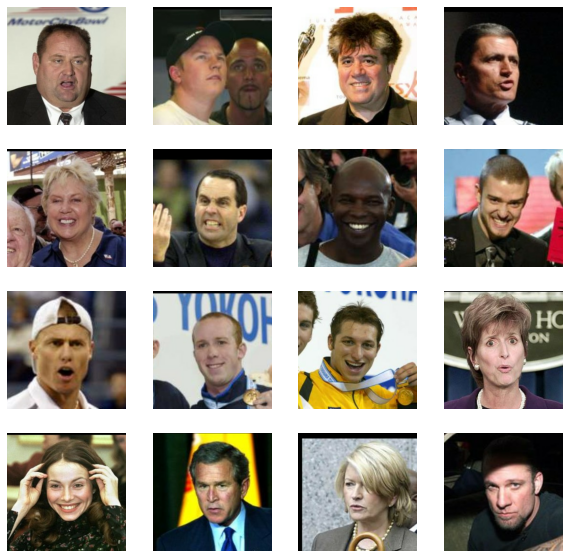

In [3]:
plt.figure(figsize=(10, 10))
for i, x in enumerate(train_ds.take(16)):
    plt.subplot(4, 4, i+1)
#     plt.title(x[0].numpy())
    plt.imshow(x[1])
    plt.axis('off')

In [4]:
batch_size = 32
half_batch_size = batch_size // 2
EPOCHS = 50
IM_SIZE = 56

def prep_imgs(_, img):
    img = tf.cast(img, tf.float32) / 255
    img = tf.image.resize(img, (IM_SIZE, IM_SIZE))
    return img

train_ds = train_ds.map(prep_imgs)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.batch(half_batch_size, drop_remainder=True)

train_ds

<BatchDataset shapes: (16, 56, 56, 3), types: tf.float32>

### model

In [5]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)), # 7x7
    
    tf.keras.layers.UpSampling2D((2, 2)), # 14x14
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    
    tf.keras.layers.UpSampling2D((2, 2)), # 28x28 
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    
    tf.keras.layers.UpSampling2D((2, 2)), # 56x56    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),  
    
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1), # ответ - настоящее (1) ли изображение или сгенерированное (0)?
])

In [6]:
# out shape check
input_dim = 100

noise = np.random.normal(0, 1, (half_batch_size, input_dim)).astype(np.float32)
syntetic_images = generator.predict(noise)
syntetic_images.shape

(16, 56, 56, 3)

In [7]:
learning_rate = 0.0002

optimizer = tf.keras.optimizers.Adam(learning_rate)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

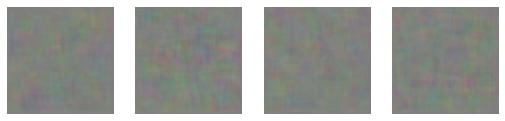

In [8]:
def plot_faces(samples):
    samples = samples / 2. + 0.5 # [-1..1] -> [0..1]
    plt.figure(figsize=(18, 2))
    for i in range(samples.shape[0]):
        plt.subplot(1, 8, i+1)
        plt.imshow(samples[i])
        plt.axis('off')
    plt.show()
    
plot_faces(syntetic_images[:4, ...])

[0] d_loss=1.034698247909546, g_loss=0.684729814529419, time 1s


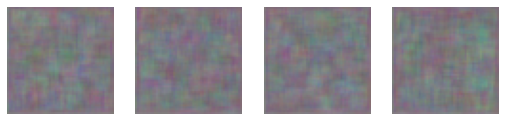

[100]...
[200]...
[300]...
[400]...
[500] d_loss=0.02044176496565342, g_loss=0.11996583640575409, time 53s


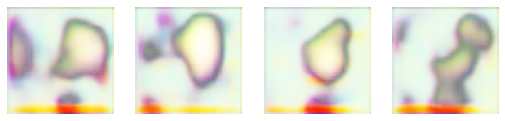

[600]...
[700]...
[800]...
[900]...
[1000] d_loss=0.12882696092128754, g_loss=4.49040412902832, time 105s


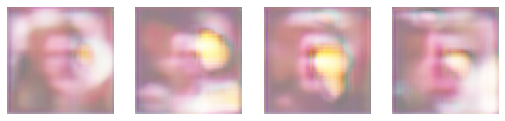

[1100]...
[1200]...
[1300]...
[1400]...
[1500] d_loss=0.7870087623596191, g_loss=13.02171802520752, time 156s


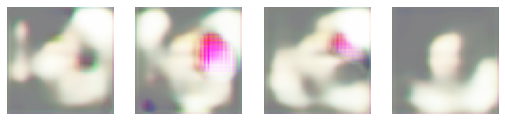

[1600]...
[1700]...
[1800]...
[1900]...
[2000] d_loss=0.1973114311695099, g_loss=1.35423743724823, time 208s


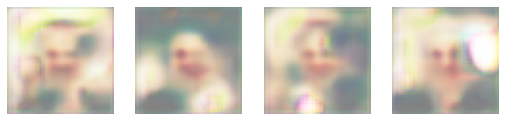

[2100]...
[2200]...
[2300]...
[2400]...
[2500] d_loss=0.008745389059185982, g_loss=6.110022068023682, time 262s


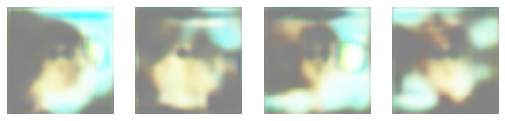

[2600]...
[2700]...
[2800]...
[2900]...
[3000] d_loss=0.5892401933670044, g_loss=0.7142472267150879, time 317s


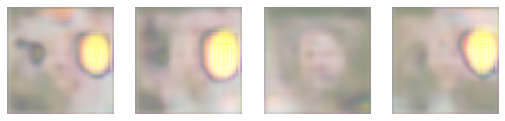

[3100]...
[3200]...
[3300]...
[3400]...
[3500] d_loss=0.7521194219589233, g_loss=7.158413887023926, time 372s


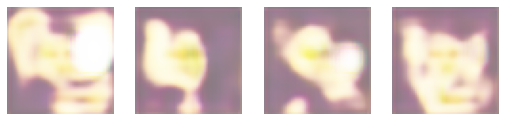

[3600]...
[3700]...
[3800]...
[3900]...
[4000] d_loss=0.1506885439157486, g_loss=4.829667091369629, time 426s


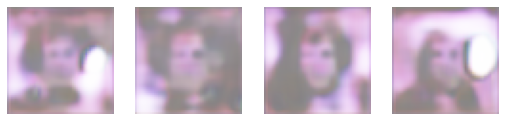

[4100]...
[4200]...
[4300]...
[4400]...
[4500] d_loss=0.7562795877456665, g_loss=0.8416563272476196, time 480s


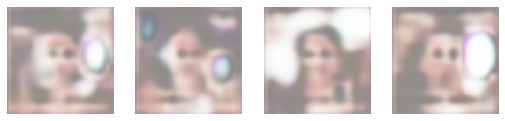

[4600]...
[4700]...
[4800]...
[4900]...
[5000] d_loss=0.015596517361700535, g_loss=2.699066638946533, time 533s


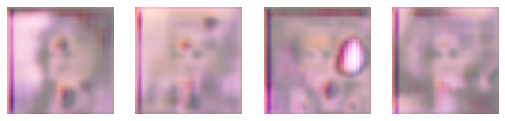

[5100]...
[5200]...
[5300]...
[5400]...
[5500] d_loss=0.9651691913604736, g_loss=0.8811588883399963, time 591s


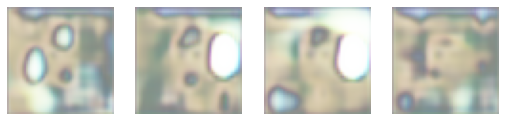

[5600]...
[5700]...
[5800]...
[5900]...
[6000] d_loss=0.5800501108169556, g_loss=2.797708034515381, time 645s


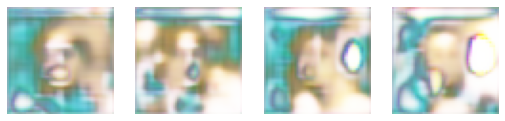

[6100]...
[6200]...
[6300]...
[6400]...
[6500] d_loss=0.2709228992462158, g_loss=5.754760265350342, time 697s


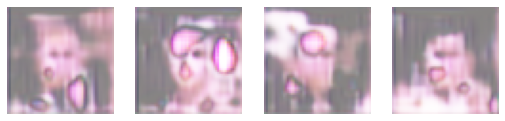

[6600]...
[6700]...
[6800]...
[6900]...
[7000] d_loss=0.09900394082069397, g_loss=2.841348171234131, time 750s


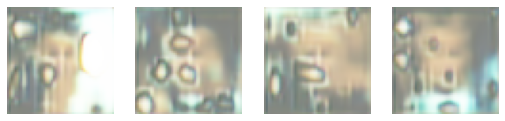

[7100]...
[7200]...
[7300]...
[7400]...
[7500] d_loss=0.11460261791944504, g_loss=5.065521717071533, time 803s


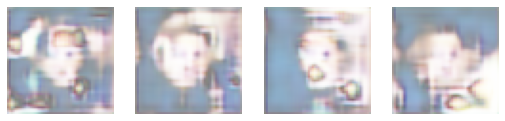

[7600]...
[7700]...
[7800]...
[7900]...
[8000] d_loss=0.09620378166437149, g_loss=3.3978734016418457, time 857s


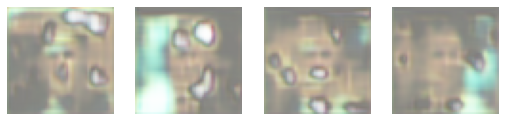

[8100]...
[8200]...
[8300]...
[8400]...
[8500] d_loss=0.7853854894638062, g_loss=2.482666492462158, time 910s


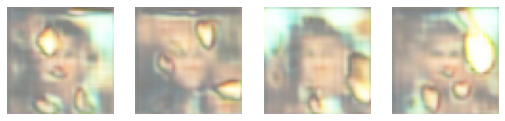

[8600]...
[8700]...
[8800]...
[8900]...
[9000] d_loss=0.2264060080051422, g_loss=1.0278278589248657, time 963s


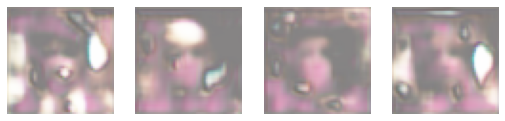

[9100]...
[9200]...
[9300]...
[9400]...
[9500] d_loss=0.24357806146144867, g_loss=2.2035748958587646, time 1015s


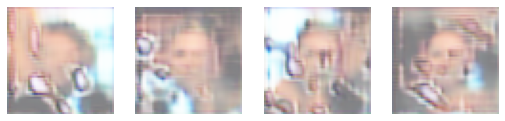

[9600]...
[9700]...
[9800]...
[9900]...
[10000] d_loss=0.20186248421669006, g_loss=5.571904182434082, time 1068s


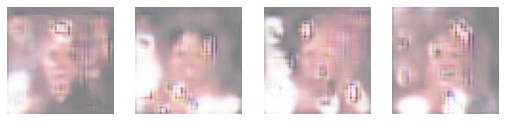

[10100]...
[10200]...
[10300]...
[10400]...
[10500] d_loss=0.7167088985443115, g_loss=0.8885787725448608, time 1121s


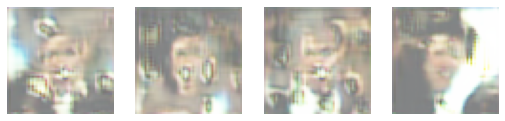

[10600]...
[10700]...
[10800]...
[10900]...
[11000] d_loss=0.6194257736206055, g_loss=4.190380096435547, time 1176s


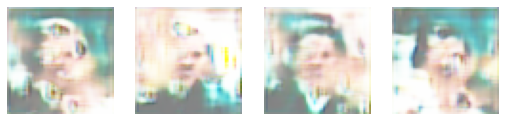

[11100]...
[11200]...
[11300]...
[11400]...
[11500] d_loss=0.8467872738838196, g_loss=0.031047886237502098, time 1230s


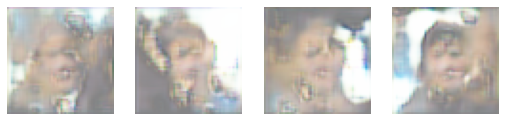

[11600]...
[11700]...
[11800]...
[11900]...
[12000] d_loss=0.3821692168712616, g_loss=2.3583831787109375, time 1286s


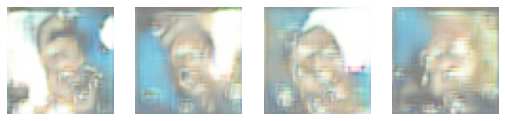

[12100]...
[12200]...
[12300]...
[12400]...
[12500] d_loss=0.6607563495635986, g_loss=2.55936861038208, time 1344s


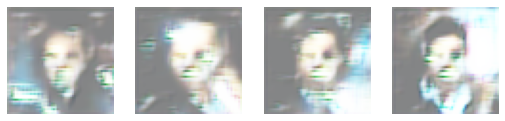

[12600]...
[12700]...
[12800]...
[12900]...
[13000] d_loss=0.4052812159061432, g_loss=2.6045665740966797, time 1400s


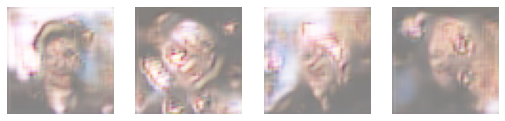

[13100]...
[13200]...
[13300]...
[13400]...
[13500] d_loss=0.5212668776512146, g_loss=0.8819918632507324, time 1456s


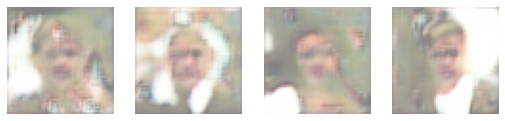

[13600]...
[13700]...
[13800]...
[13900]...
[14000] d_loss=0.4897885024547577, g_loss=0.6920534372329712, time 1510s


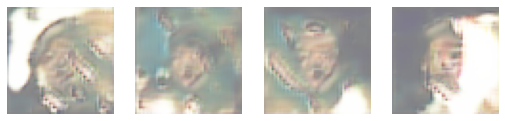

[14100]...
[14200]...
[14300]...
[14400]...
[14500] d_loss=0.5227732062339783, g_loss=3.5194849967956543, time 1563s


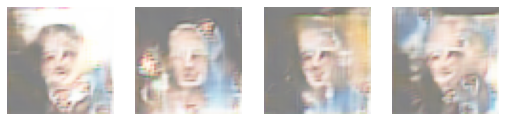

[14600]...
[14700]...
[14800]...
[14900]...
[15000] d_loss=0.17745035886764526, g_loss=3.0106749534606934, time 1617s


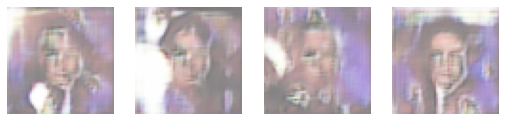

[15100]...
[15200]...
[15300]...
[15400]...
[15500] d_loss=0.3208619952201843, g_loss=2.4194722175598145, time 1677s


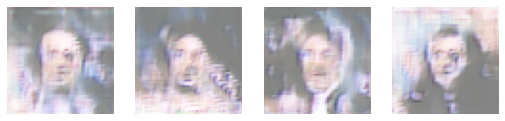

[15600]...
[15700]...
[15800]...
[15900]...
[16000] d_loss=0.10643438249826431, g_loss=2.160156726837158, time 1730s


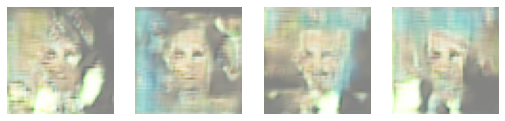

[16100]...
[16200]...
[16300]...
[16400]...
[16500] d_loss=0.7601666450500488, g_loss=2.317321300506592, time 1784s


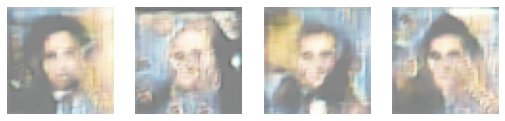

[16600]...
[16700]...
[16800]...
[16900]...
[17000] d_loss=0.4090246856212616, g_loss=2.4809770584106445, time 1838s


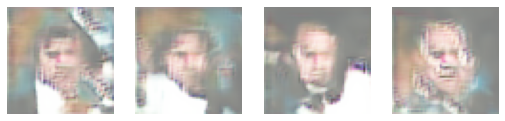

[17100]...
[17200]...
[17300]...
[17400]...
[17500] d_loss=0.8468564748764038, g_loss=0.8863736391067505, time 1897s


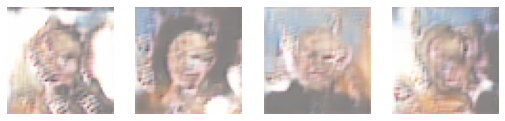

[17600]...
[17700]...
[17800]...
[17900]...
[18000] d_loss=0.25831717252731323, g_loss=1.3272521495819092, time 1950s


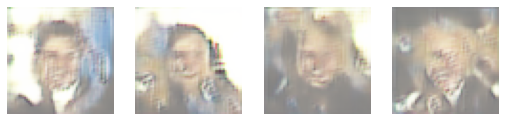

[18100]...
[18200]...
[18300]...
[18400]...
[18500] d_loss=0.20845761895179749, g_loss=1.577222228050232, time 2003s


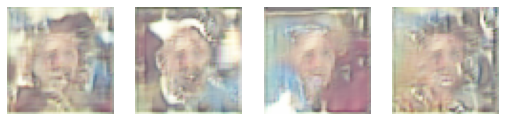

[18600]...
[18700]...
[18800]...
[18900]...
[19000] d_loss=0.47514578700065613, g_loss=2.1223535537719727, time 2057s


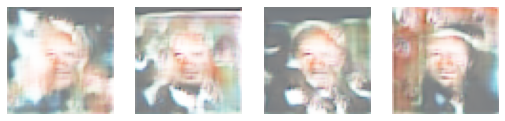

[19100]...
[19200]...
[19300]...
[19400]...
[19500] d_loss=0.15727216005325317, g_loss=2.7932567596435547, time 2109s


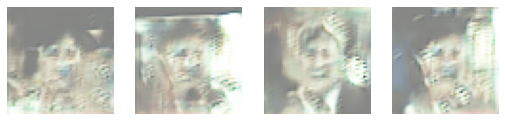

[19600]...
[19700]...
[19800]...
[19900]...
[20000] d_loss=0.3104202151298523, g_loss=1.7793306112289429, time 2162s


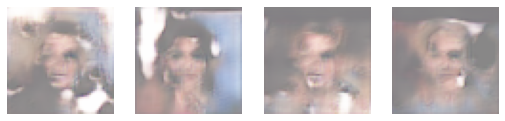

[20100]...
[20200]...
[20300]...
[20400]...
[20500] d_loss=0.6554181575775146, g_loss=3.2169504165649414, time 2214s


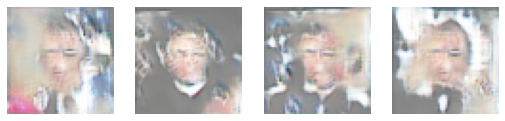

[20600]...
[20700]...
[20800]...
[20900]...
[21000] d_loss=0.5471692085266113, g_loss=0.7395851612091064, time 2267s


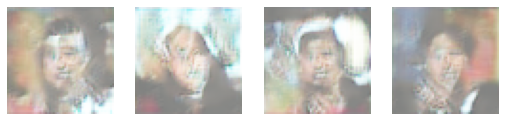

[21100]...
[21200]...
[21300]...
[21400]...
[21500] d_loss=0.4242020547389984, g_loss=2.4402740001678467, time 2319s


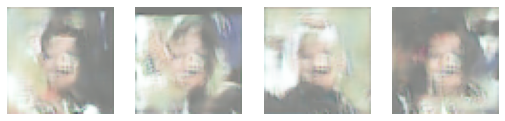

[21600]...
[21700]...
[21800]...
[21900]...
[22000] d_loss=0.4490092396736145, g_loss=2.027939796447754, time 2372s


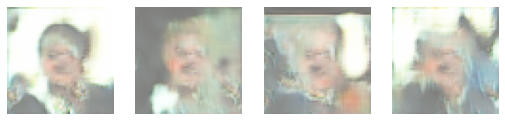

[22100]...
[22200]...
[22300]...
[22400]...
[22500] d_loss=0.42998793721199036, g_loss=1.714022159576416, time 2426s


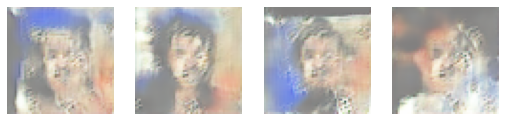

[22600]...
[22700]...
[22800]...
[22900]...
[23000] d_loss=0.4316202998161316, g_loss=3.4973976612091064, time 2478s


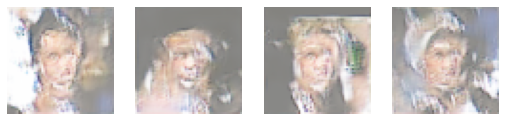

[23100]...
[23200]...
[23300]...
[23400]...
[23500] d_loss=0.5337350368499756, g_loss=1.8138601779937744, time 2530s


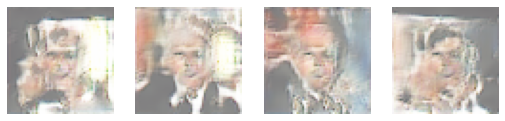

[23600]...
[23700]...
[23800]...
[23900]...
[24000] d_loss=0.3949843645095825, g_loss=1.6693089008331299, time 2583s


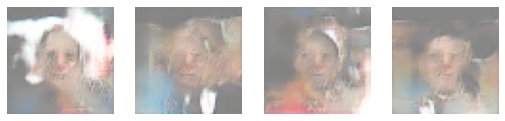

[24100]...
[24200]...
[24300]...
[24400]...
[24500] d_loss=0.758948564529419, g_loss=0.9158666729927063, time 2635s


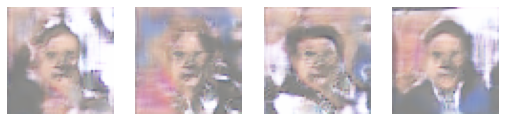

[24600]...
[24700]...
[24800]...
[24900]...
[25000] d_loss=0.4731001555919647, g_loss=2.007063388824463, time 2688s


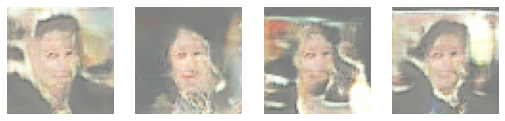

[25100]...
[25200]...
[25300]...
[25400]...
[25500] d_loss=0.37136024236679077, g_loss=2.916367530822754, time 2740s


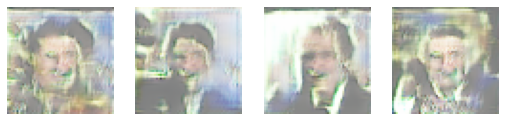

[25600]...
[25700]...
[25800]...
[25900]...
[26000] d_loss=0.3159591853618622, g_loss=3.3668107986450195, time 2793s


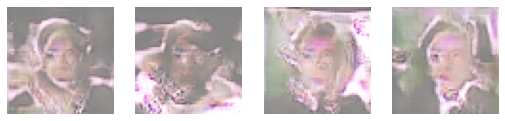

[26100]...
[26200]...
[26300]...
[26400]...
[26500] d_loss=0.2832801043987274, g_loss=2.201446056365967, time 2846s


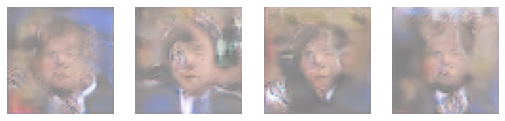

[26600]...
[26700]...
[26800]...
[26900]...
[27000] d_loss=0.42346465587615967, g_loss=3.3109517097473145, time 2898s


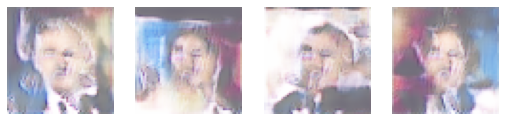

[27100]...
[27200]...
[27300]...
[27400]...
[27500] d_loss=0.35935744643211365, g_loss=1.7906391620635986, time 2951s


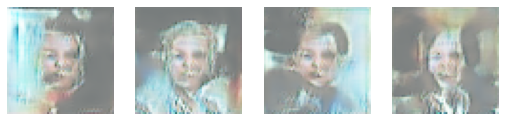

[27600]...
[27700]...
[27800]...
[27900]...
[28000] d_loss=0.37742507457733154, g_loss=1.7700591087341309, time 3004s


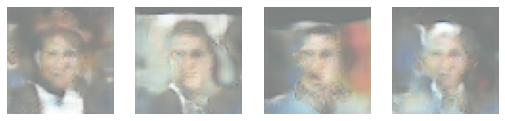

[28100]...
[28200]...
[28300]...
[28400]...
[28500] d_loss=0.4648077189922333, g_loss=2.4351553916931152, time 3058s


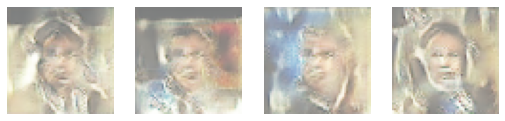

[28600]...
[28700]...
[28800]...
[28900]...
[29000] d_loss=0.42748868465423584, g_loss=1.7904855012893677, time 3110s


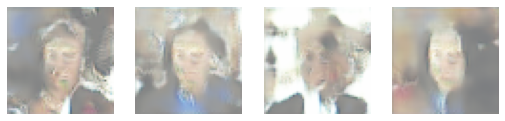

[29100]...
[29200]...
[29300]...
[29400]...
[29500] d_loss=0.7473661303520203, g_loss=1.2791576385498047, time 3163s


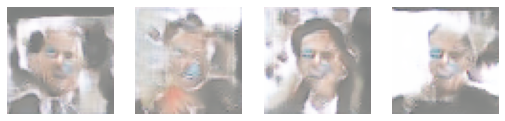

[29600]...
[29700]...
[29800]...
[29900]...
[30000] d_loss=0.48538732528686523, g_loss=1.727287769317627, time 3216s


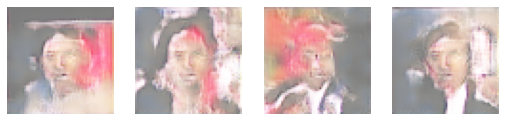

[30100]...
[30200]...
[30300]...
[30400]...
[30500] d_loss=0.3639010190963745, g_loss=1.497788429260254, time 3268s


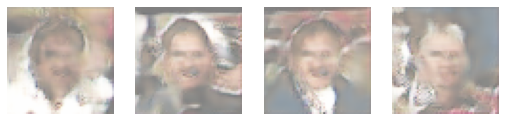

[30600]...
[30700]...
[30800]...
[30900]...
[31000] d_loss=0.40192124247550964, g_loss=2.132293701171875, time 3321s


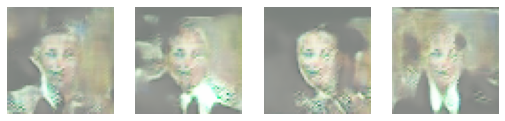

[31100]...
[31200]...
[31300]...
[31400]...
[31500] d_loss=0.5487052202224731, g_loss=1.8867509365081787, time 3374s


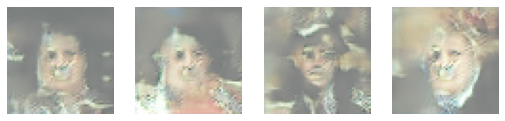

[31600]...
[31700]...
[31800]...
[31900]...
[32000] d_loss=0.4505164921283722, g_loss=1.4177861213684082, time 3427s


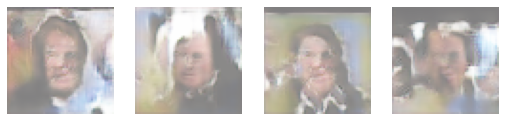

[32100]...
[32200]...
[32300]...
[32400]...
[32500] d_loss=0.3284555673599243, g_loss=2.4948408603668213, time 3479s


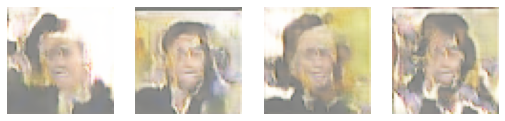

[32600]...
[32700]...
[32800]...
[32900]...
[33000] d_loss=0.27433040738105774, g_loss=2.1283774375915527, time 3532s


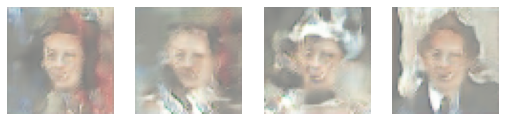

[33100]...
[33200]...
[33300]...
[33400]...
[33500] d_loss=0.7488542795181274, g_loss=1.0570995807647705, time 3584s


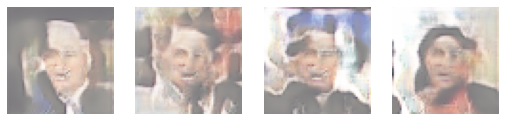

[33600]...
[33700]...
[33800]...
[33900]...
[34000] d_loss=0.3486332893371582, g_loss=1.3548755645751953, time 3637s


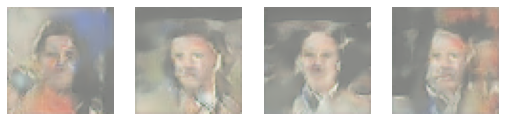

[34100]...
[34200]...
[34300]...
[34400]...
[34500] d_loss=0.8876828551292419, g_loss=1.0655417442321777, time 3691s


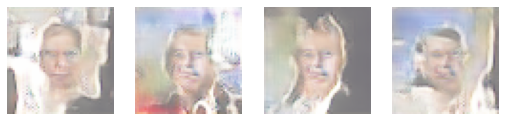

[34600]...
[34700]...
[34800]...
[34900]...
[35000] d_loss=0.46203964948654175, g_loss=1.1364209651947021, time 3746s


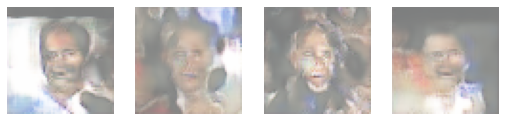

[35100]...
[35200]...
[35300]...
[35400]...
[35500] d_loss=0.7445047497749329, g_loss=1.6524966955184937, time 3799s


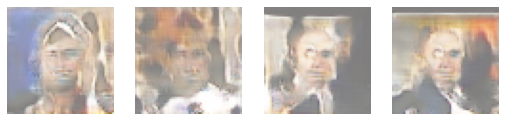

[35600]...
[35700]...
[35800]...
[35900]...
[36000] d_loss=0.7611189484596252, g_loss=1.0136618614196777, time 3856s


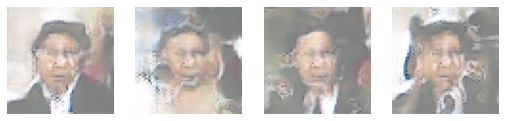

[36100]...
[36200]...
[36300]...
[36400]...
[36500] d_loss=0.46955597400665283, g_loss=3.5028440952301025, time 3909s


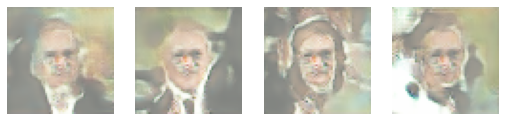

[36600]...
[36700]...
[36800]...
[36900]...
[37000] d_loss=0.8379049301147461, g_loss=0.23625971376895905, time 3968s


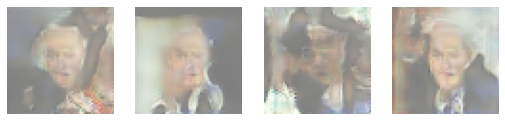

[37100]...
[37200]...
[37300]...
[37400]...
[37500] d_loss=0.41590332984924316, g_loss=1.6195476055145264, time 4024s


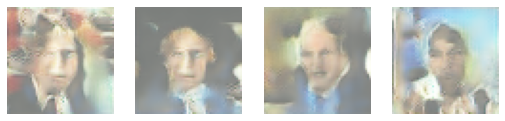

[37600]...
[37700]...
[37800]...
[37900]...
[38000] d_loss=0.3079163134098053, g_loss=2.2929420471191406, time 4081s


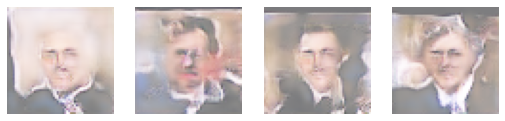

[38100]...
[38200]...
[38300]...
[38400]...
[38500] d_loss=0.31108078360557556, g_loss=1.547032356262207, time 4134s


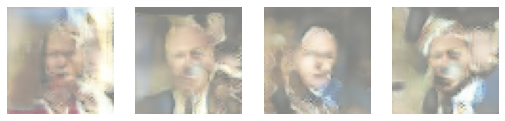

[38600]...
[38700]...
[38800]...
[38900]...
[39000] d_loss=0.42534154653549194, g_loss=0.9524828195571899, time 4188s


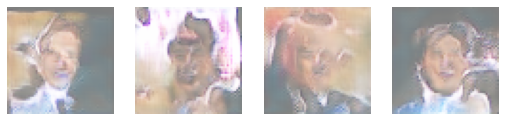

[39100]...
[39200]...
[39300]...
[39400]...
[39500] d_loss=0.7499570846557617, g_loss=1.469954490661621, time 4251s


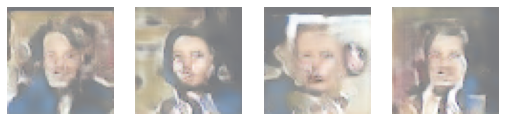

[39600]...
[39700]...
[39800]...
[39900]...
[40000] d_loss=0.6676735877990723, g_loss=1.0105708837509155, time 4309s


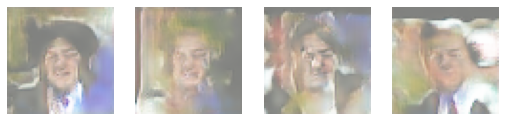

[40100]...
[40200]...
[40300]...
[40400]...
[40500] d_loss=0.770755410194397, g_loss=1.320122480392456, time 4367s


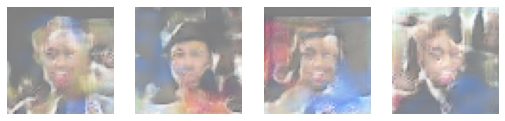

[40600]...
[40700]...
[40800]...
[40900]...
Wall time: 1h 13min 40s


In [9]:
%%time
start_time = time.time()

d_loss = []
g_loss = []


for step, (true_images) in enumerate(train_ds):

    # Train Discriminator
    noise = np.random.normal(0, 1, (half_batch_size, input_dim)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((half_batch_size, 1), np.float32), 
        np.zeros((half_batch_size, 1), np.float32)))

    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    d_loss.append(d_loss_value)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, input_dim)).astype(np.float32)
    y_mislabled = np.ones((batch_size, 1), np.float32)

    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    g_loss.append(g_loss_value)

    # Check intermediate results
    if step % 500 == 0:
        print(f'[{step}] d_loss={d_loss_value.numpy()}, g_loss={g_loss_value.numpy()}, time {int(time.time()-start_time)}s')

        noise = np.random.normal(0, 1, (8, input_dim)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_faces(syntetic_images[:4, ...])
    elif step % 100 == 0:
        print(f'[{step}] ...')

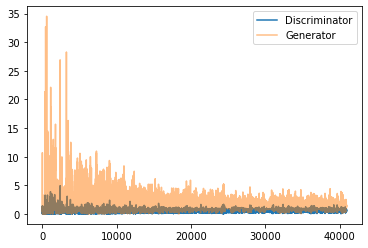

In [10]:
plt.plot(d_loss, label="Discriminator")
plt.plot(g_loss, label="Generator", alpha=0.5)
plt.legend()

### image sample

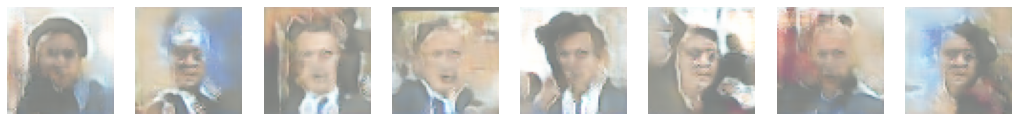

In [11]:
noise = np.random.normal(0, 1, (half_batch_size, input_dim)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_faces(syntetic_images[:8, ...])

на 50 эпохах пока страшненькие)